In [1]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, fpgrowth
from itertools import combinations
from pyECLAT import ECLAT
from time import time
from matplotlib import pyplot as plt

In [2]:
# Считываем данные из csv
data = pd.read_csv('retail_dataset.csv', dtype='str')
data.columns = range(data.shape[1])
data

,0,1,2,3,4,5,6
0,Bread,Wine,Eggs,Meat,Cheese,Pencil,Diaper
1,Bread,Cheese,Meat,Diaper,Wine,Milk,Pencil
2,Cheese,Meat,Eggs,Milk,Wine,NaN,NaN
3,Cheese,Meat,Eggs,Milk,Wine,NaN,NaN
4,Meat,Pencil,Wine,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
310,Bread,Eggs,Cheese,NaN,NaN,NaN,NaN
311,Meat,Milk,Pencil,NaN,NaN,NaN,NaN
312,Bread,Cheese,Eggs,Meat,Pencil,Diaper,Wine
313,Meat,Cheese,NaN,NaN,NaN,NaN,NaN


In [3]:
# извлекаем все названия продуктов
names = set(pd.Series(data.values.flatten()).dropna().unique().tolist())
names

{'Bagel',
 'Bread',
 'Cheese',
 'Diaper',
 'Eggs',
 'Meat',
 'Milk',
 'Pencil',
 'Wine'}

In [4]:
# Преобразуем в таблицу с бинарными данными
transactions = pd.DataFrame([{name: name in x.dropna().unique() for name in names} for x in data.iloc])
transactions

,Bagel,Wine,Eggs,Pencil,Meat,Diaper,Bread,Cheese,Milk
0,False,True,True,True,True,True,True,True,False
1,False,True,False,True,True,True,True,True,True
2,False,True,True,False,True,False,False,True,True
3,False,True,True,False,True,False,False,True,True
4,False,True,False,True,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...
310,False,False,True,False,False,False,True,True,False
311,False,False,False,True,True,False,False,False,True
312,False,True,True,True,True,True,True,True,False
313,False,False,False,False,True,False,False,True,False


In [5]:
# Запустить алгоритмы apriori, fpgrowth и eclat
# data - исходная таблица с данными (для ECLAT)
# transactions - бинарные данные (для apriori, fpgrowth)
# min_support - пороговое значение поддержки
# Выход: таблицы с результатами работы трёх алгоритмов, время работы алгоритмов в секундах 
def fit(data, transactions, min_support):
    t0 = time()
    apriori_results = apriori(transactions, min_support=min_support, use_colnames=True)
    t1 = time()
    fpgrowth_results = fpgrowth(transactions, min_support=min_support, use_colnames=True)
    t2 = time()
    eclat = ECLAT(data=data)
    t3 = time()
    _, eclat_supports = eclat.fit(min_support=min_support,
        min_combination=1,
        max_combination=max(eclat.df_bin.astype(int).sum(axis=1)),
        separator=',',
        verbose=False)
    eclat_results = pd.DataFrame(sorted(zip(
        eclat_supports.values(),
        map(lambda x: frozenset(x.split(',')), eclat_supports.keys())
    ), key = lambda x: x[0], reverse=True), columns = ['support', 'itemsets'])

    return (apriori_results, fpgrowth_results, eclat_results), (t1 - t0, t2 - t1, t3 - t2)

In [6]:
# Вычислить максимальный MSE для значений поддержки, полученных разными алгоритмами
def calc_mse(a, f, e):
    def results_to_dict(results):
        return dict(zip(results.itemsets, results.support))
        
    def mse(x1, x2):
        return np.sum((x1 - x2) ** 2)

    apriori_d = results_to_dict(apriori_results)
    fpgrowth_d = results_to_dict(fpgrowth_results)
    eclat_d = results_to_dict(eclat_results)

    assert(apriori_d.keys() == fpgrowth_d.keys() and apriori_d.keys() == eclat_d.keys())

    keys = sorted(apriori_d.keys())
    arr = np.stack([np.array([apriori_d[itemset], fpgrowth_d[itemset], eclat_d[itemset]]) for itemset in keys])

    if np.all(arr[:,0] == arr[:,1]) and np.all(arr[:,1] == arr[:,2]):
        print("Результаты равны")

    return max(mse(arr[:,0], arr[:,1]), mse(arr[:,0], arr[:,2]), mse(arr[:,1], arr[:,2]))

In [7]:
# Выведем результаты для порогового значения в 5%
apriori_results, fpgrowth_results, eclat_results = fit(data, transactions, 0.05)[0]
calc_mse(apriori_results, fpgrowth_results, eclat_results)

Результаты равны


np.float64(0.0)

In [8]:
apriori_results

,support,itemsets
0,0.425397,(Bagel)
1,0.438095,(Wine)
2,0.438095,(Eggs)
3,0.361905,(Pencil)
4,0.476190,(Meat)
...,...,...
204,0.066667,"(Diaper, Bread, Cheese, Milk)"
205,0.073016,"(Wine, Eggs, Meat, Cheese, Milk)"
206,0.050794,"(Wine, Eggs, Bread, Cheese, Milk)"
207,0.053968,"(Wine, Pencil, Meat, Bread, Cheese)"


In [9]:
fpgrowth_results

,support,itemsets
0,0.504762,(Bread)
1,0.501587,(Cheese)
2,0.476190,(Meat)
3,0.438095,(Eggs)
4,0.438095,(Wine)
...,...,...
204,0.120635,"(Meat, Cheese, Bagel)"
205,0.114286,"(Meat, Bread, Bagel)"
206,0.076190,"(Meat, Milk, Bagel)"
207,0.066667,"(Meat, Bread, Cheese, Bagel)"


In [10]:
eclat_results

,support,itemsets
0,0.504762,(Bread)
1,0.501587,(Cheese)
2,0.501587,(Milk)
3,0.476190,(Meat)
4,0.438095,(Wine)
...,...,...
204,0.050794,"(Meat, Wine, Milk, Pencil)"
205,0.050794,"(Cheese, Milk, Eggs, Pencil)"
206,0.050794,"(Diaper, Milk, Bread, Eggs)"
207,0.050794,"(Diaper, Bread, Milk, Pencil)"


In [11]:
# Сравним показатели при разных пороговых значениях

mins = [0.01, 0.03, 0.05, 0.10, 0.15, 0.20]

time_arr = np.zeros((len(mins), 3))
count_arr = np.zeros(len(mins), dtype=np.int64)
maxlen_arr = np.zeros(len(mins), dtype=np.int64)
counts_arr = {n : np.zeros(len(mins), dtype=np.int64) for n in range(1, len(data.columns)+1)}

for i, min_support in enumerate(mins):
    (apriori_results, fpgrowth_results, eclat_results), (t_a, t_f, t_e) = fit(data, transactions, min_support)
    mse = calc_mse(apriori_results, fpgrowth_results, eclat_results).item()
    count = len(apriori_results)
    maxlen = max([len(x) for x in apriori_results.itemsets])
    counts = np.array([len(x) for x in apriori_results.itemsets])
    counts = {n : np.sum(counts == n).item() for n in range(1, maxlen+1)}
    print(f"{min_support = }\n\tКоличество: {count}\n\tМаксимальная длина: {maxlen}")
    print(f"\tКоличество по длинам: {counts}")
    print(f"\t{mse = }\n\t{t_a = }\n\t{t_f = }\n\t{t_e = }\n")
    time_arr[i] = np.array([t_a, t_f, t_e])
    count_arr[i] = count
    maxlen_arr[i] = maxlen
    for (n, c) in counts.items():
        counts_arr[n][i] = c

Результаты равны
min_support = 0.01
	Количество: 422
	Максимальная длина: 7
	Количество по длинам: {1: 9, 2: 36, 3: 84, 4: 126, 5: 120, 6: 45, 7: 2}
	mse = 0.0
	t_a = 0.007487773895263672
	t_f = 0.28716564178466797
	t_e = 0.010903120040893555

Результаты равны
min_support = 0.03
	Количество: 301
	Максимальная длина: 6
	Количество по длинам: {1: 9, 2: 36, 3: 84, 4: 123, 5: 48, 6: 1}
	mse = 0.0
	t_a = 0.004670381546020508
	t_f = 0.1914372444152832
	t_e = 0.010931015014648438

Результаты равны
min_support = 0.05
	Количество: 209
	Максимальная длина: 5
	Количество по длинам: {1: 9, 2: 36, 3: 84, 4: 76, 5: 4}
	mse = 0.0
	t_a = 0.0036745071411132812
	t_f = 0.1318502426147461
	t_e = 0.011051416397094727

Результаты равны
min_support = 0.1
	Количество: 100
	Максимальная длина: 4
	Количество по длинам: {1: 9, 2: 36, 3: 51, 4: 4}
	mse = 0.0
	t_a = 0.0025589466094970703
	t_f = 0.058745622634887695
	t_e = 0.010348081588745117

Результаты равны
min_support = 0.15
	Количество: 54
	Максимальная длина

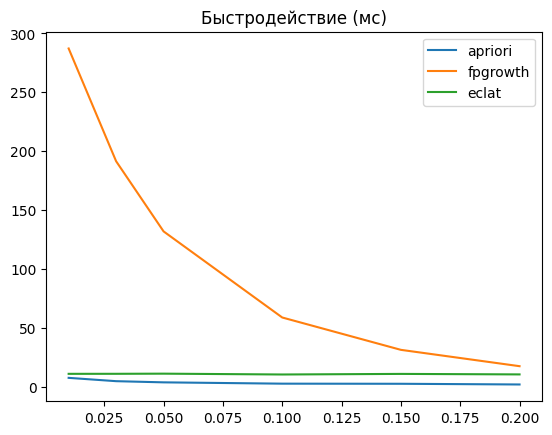

In [12]:
# Построим соответствующие диаграммы
plt.plot(mins, time_arr * 1000, label=["apriori", "fpgrowth", "eclat"])
plt.legend()
plt.title("Быстродействие (мс)")
plt.show()

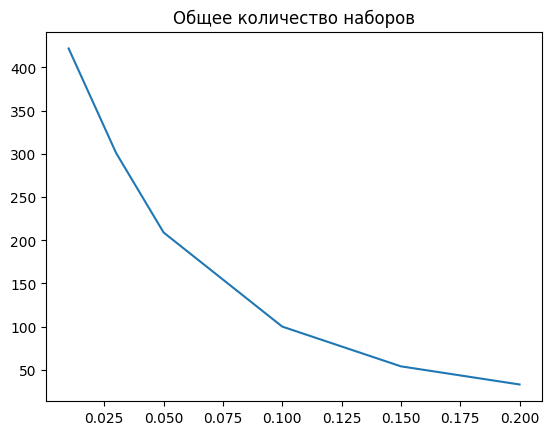

In [13]:
plt.plot(mins, count_arr)
plt.title("Общее количество наборов")
plt.show()

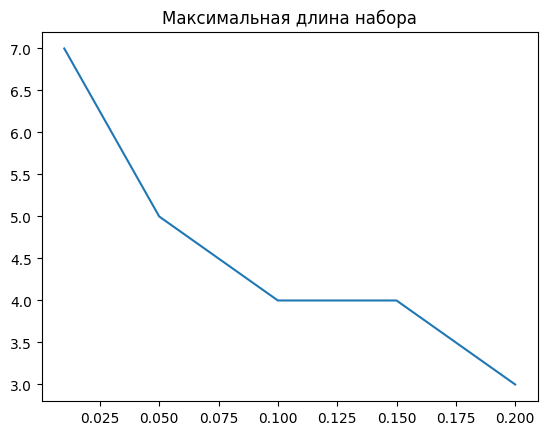

In [14]:
plt.plot(mins, maxlen_arr)
plt.title("Максимальная длина набора")
plt.show()

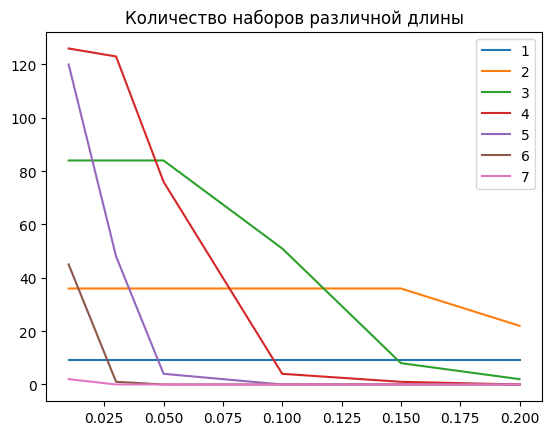

In [15]:
plt.plot(mins, np.array([x for x in counts_arr.values()]).T, label=counts_arr.keys())
plt.legend()
plt.title("Количество наборов различной длины")
plt.show()